<!-- NAVIGATION -->
< [Chapter 10. Big Entropy and the Generalized Linear Model](10-big-entropy-and-the-generalized-linear-model.html) | [Chapter 12. Monsters and Mixtures](12-monsters-and-mixtures.html) >

In [0]:
import math
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

import jax.numpy as jnp
from jax import nn, ops, random, vmap
from jax.scipy.special import expit

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import print_summary
from numpyro.infer import MCMC, NUTS, Predictive, SVI, Trace_ELBO, log_likelihood
from numpyro.infer.autoguide import AutoLaplaceApproximation

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")
numpyro.set_host_device_count(4)

### Code 11.1

In [1]:
chimpanzees = pd.read_csv("../data/chimpanzees.csv", sep=";")
d = chimpanzees

### Code 11.2

In [2]:
d["treatment"] = d.prosoc_left + 2 * d.condition

### Code 11.3

In [3]:
d.reset_index().groupby(["condition", "prosoc_left", "treatment"]).count()["index"]

condition  prosoc_left  treatment
0          0            0            126
           1            1            126
1          0            2            126
           1            3            126
Name: index, dtype: int64

### Code 11.4

In [4]:
def model(pulled_left=None):
    a = numpyro.sample("a", dist.Normal(0, 10))
    logit_p = a
    numpyro.sample("pulled_left", dist.Binomial(logits=logit_p), obs=pulled_left)


m11_1 = AutoLaplaceApproximation(model)
svi = SVI(model, m11_1, optim.Adam(1), Trace_ELBO(), pulled_left=d.pulled_left.values)
p11_1, losses = svi.run(random.PRNGKey(0), 1000)

100%|██████████| 1000/1000 [00:00<00:00, 1410.82it/s, init loss: 346.7780, avg. loss [951-1000]: 339.2683]


### Code 11.5

In [5]:
prior = Predictive(m11_1.model, num_samples=10000)(random.PRNGKey(1999))

### Code 11.6

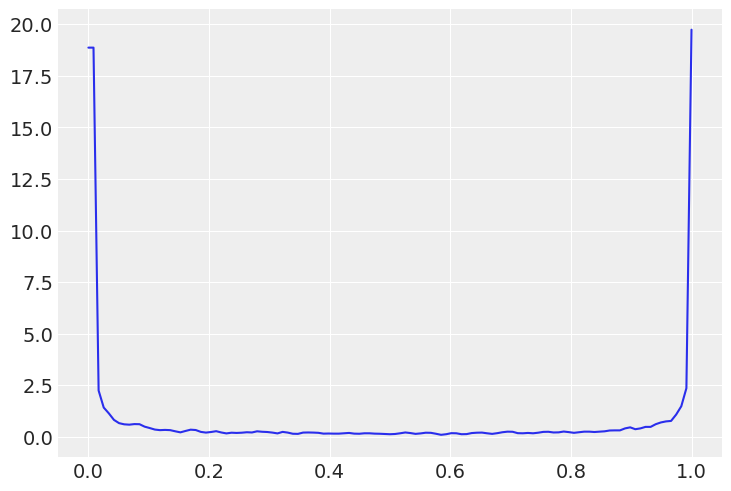

In [6]:
p = expit(prior["a"])
az.plot_kde(p, bw=0.3)
plt.show()

### Code 11.7

In [7]:
def model(treatment, pulled_left=None):
    a = numpyro.sample("a", dist.Normal(0, 1.5))
    b = numpyro.sample("b", dist.Normal(0, 10).expand([4]))
    logit_p = a + b[treatment]
    numpyro.sample("pulled_left", dist.Binomial(logits=logit_p), obs=pulled_left)


m11_2 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m11_2,
    optim.Adam(1),
    Trace_ELBO(),
    treatment=d.treatment.values,
    pulled_left=d.pulled_left.values,
)
p11_2, losses = svi.run(random.PRNGKey(0), 1000)
prior = Predictive(model, num_samples=int(1e4))(
    random.PRNGKey(1999), treatment=0, pulled_left=0
)
p = vmap(lambda k: expit(prior["a"] + prior["b"][:, k]), 0, 1)(jnp.arange(4))

100%|██████████| 1000/1000 [00:00<00:00, 1423.63it/s, init loss: 414.9600, avg. loss [951-1000]: 344.7054]


### Code 11.8

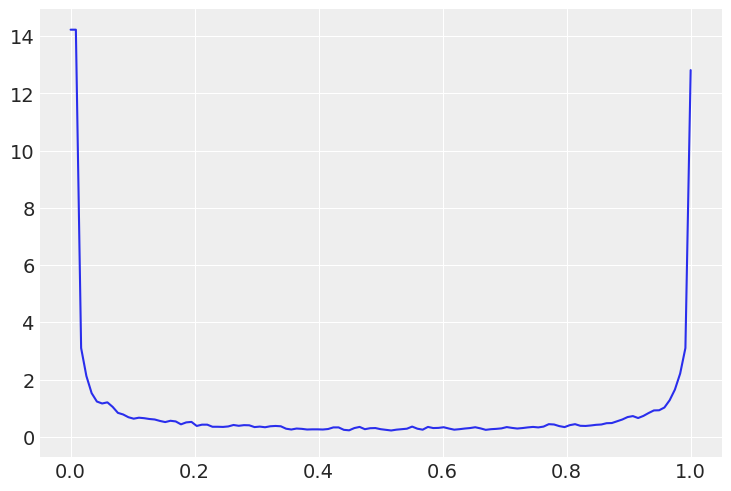

In [8]:
az.plot_kde(jnp.abs(p[:, 0] - p[:, 1]), bw=0.3)
plt.show()

### Code 11.9

In [9]:
def model(treatment, pulled_left=None):
    a = numpyro.sample("a", dist.Normal(0, 1.5))
    b = numpyro.sample("b", dist.Normal(0, 0.5).expand([4]))
    logit_p = a + b[treatment]
    numpyro.sample("pulled_left", dist.Binomial(logits=logit_p), obs=pulled_left)


m11_3 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m11_3,
    optim.Adam(1),
    Trace_ELBO(),
    treatment=d.treatment.values,
    pulled_left=d.pulled_left.values,
)
p11_3, losses = svi.run(random.PRNGKey(0), 1000)
prior = Predictive(model, num_samples=int(1e4))(
    random.PRNGKey(1999), treatment=0, pulled_left=0
)
p = vmap(lambda k: expit(prior["a"] + prior["b"][:, k]), 0, 1)(jnp.arange(4))
jnp.mean(jnp.abs(p[:, 0] - p[:, 1]))

100%|██████████| 1000/1000 [00:00<00:00, 1388.03it/s, init loss: 414.5659, avg. loss [951-1000]: 333.5991]


DeviceArray(0.09770478, dtype=float32)

### Code 11.10

In [10]:
# trimmed data list
dat_list = {
    "pulled_left": d.pulled_left.values,
    "actor": d.actor.values - 1,
    "treatment": d.treatment.values,
}

### Code 11.11

In [11]:
def model(actor, treatment, pulled_left=None, link=False):
    a = numpyro.sample("a", dist.Normal(0, 1.5).expand([7]))
    b = numpyro.sample("b", dist.Normal(0, 0.5).expand([4]))
    logit_p = a[actor] + b[treatment]
    if link:
        numpyro.deterministic("p", expit(logit_p))
    numpyro.sample("pulled_left", dist.Binomial(logits=logit_p), obs=pulled_left)


m11_4 = MCMC(NUTS(model), 500, 500, num_chains=4)
m11_4.run(random.PRNGKey(0), **dat_list)
m11_4.print_summary(0.89)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]     -0.46      0.34     -0.46     -0.98      0.09    662.21      1.01
      a[1]      3.89      0.77      3.84      2.74      5.11   2026.28      1.00
      a[2]     -0.75      0.34     -0.75     -1.28     -0.21    600.91      1.01
      a[3]     -0.75      0.33     -0.74     -1.28     -0.23    613.81      1.00
      a[4]     -0.46      0.34     -0.45     -1.02      0.06    617.91      1.01
      a[5]      0.48      0.34      0.47     -0.12      0.96    646.39      1.01
      a[6]      1.96      0.43      1.95      1.26      2.63    966.31      1.00
      b[0]     -0.03      0.29     -0.04     -0.48      0.45    551.43      1.01
      b[1]      0.48      0.29      0.48      0.01      0.95    567.56      1.01
      b[2]     -0.38      0.29     -0.38     -0.83      0.10    551.80      1.01
      b[3]      0.38      0.29      0.37     -0.09      0.81    521.26      1.01

Number of divergences: 0


### Code 11.12

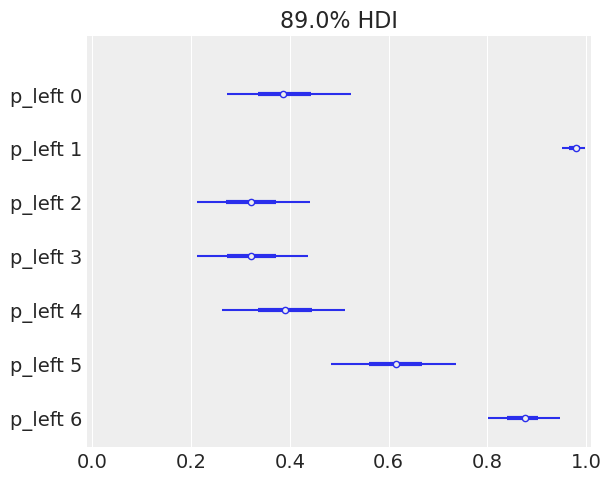

In [12]:
post = m11_4.get_samples(group_by_chain=True)
p_left = expit(post["a"])
az.plot_forest({"p_left": p_left}, combined=True, hdi_prob=0.89)
plt.gca().set(xlim=(-0.01, 1.01))
plt.show()

### Code 11.13

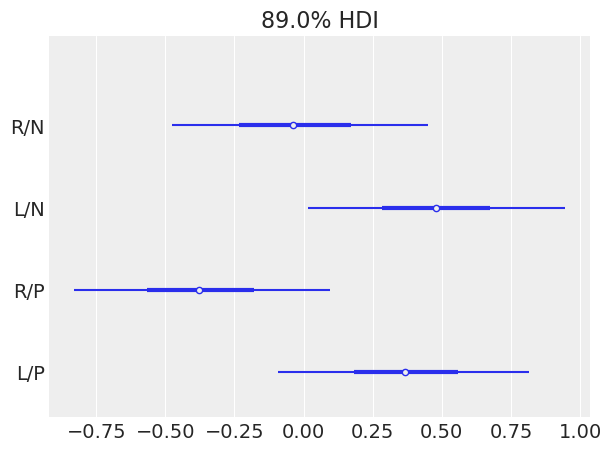

In [13]:
labs = ["R/N", "L/N", "R/P", "L/P"]
az.plot_forest(
    m11_4.get_samples(group_by_chain=True), combined=True, var_names="b", hdi_prob=0.89,
)
plt.gca().set_yticklabels(labs[::-1])
plt.show()

### Code 11.14

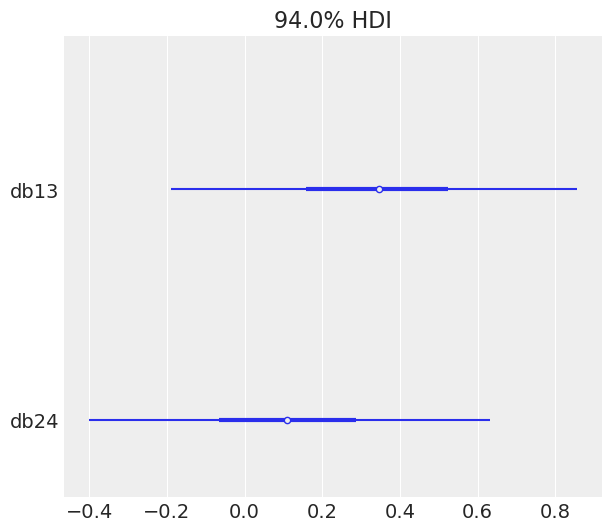

In [14]:
diffs = {
    "db13": post["b"][..., 0] - post["b"][..., 2],
    "db24": post["b"][..., 1] - post["b"][..., 3],
}
az.plot_forest(diffs, combined=True)
plt.show()

### Code 11.15

In [15]:
pl = d.groupby(["actor", "treatment"])["pulled_left"].mean().unstack()
pl.iloc[0, :]

treatment
0    0.333333
1    0.500000
2    0.277778
3    0.555556
Name: 1, dtype: float64

### Code 11.16

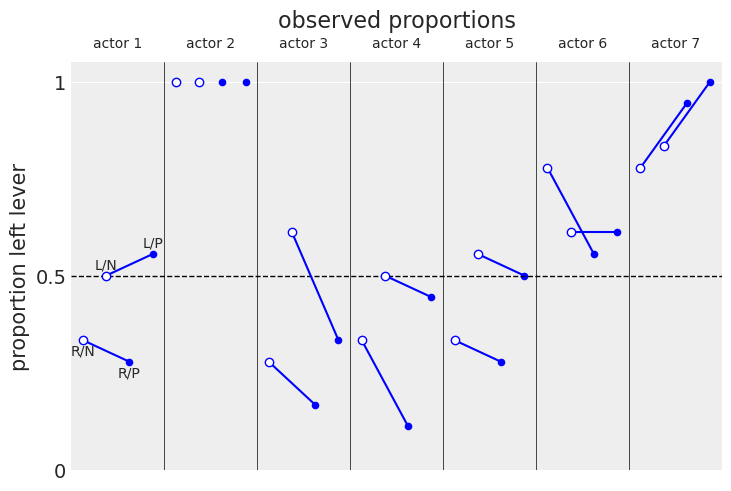

In [16]:
ax = plt.subplot(
    xlim=(0.5, 28.5),
    ylim=(0, 1.05),
    xlabel="",
    ylabel="proportion left lever",
    xticks=[],
)
plt.yticks(ticks=[0, 0.5, 1], labels=[0, 0.5, 1])
ax.axhline(0.5, c="k", lw=1, ls="--")
for j in range(1, 8):
    ax.axvline((j - 1) * 4 + 4.5, c="k", lw=0.5)
for j in range(1, 8):
    ax.annotate(
        "actor {}".format(j),
        ((j - 1) * 4 + 2.5, 1.1),
        ha="center",
        va="center",
        annotation_clip=False,
    )
for j in [1] + list(range(3, 8)):
    ax.plot((j - 1) * 4 + jnp.array([1, 3]), pl.loc[j, [0, 2]], "b")
    ax.plot((j - 1) * 4 + jnp.array([2, 4]), pl.loc[j, [1, 3]], "b")
x = jnp.arange(1, 29).reshape(7, 4)
ax.scatter(
    x[:, [0, 1]].reshape(-1),
    pl.values[:, [0, 1]].reshape(-1),
    edgecolor="b",
    facecolor="w",
    zorder=3,
)
ax.scatter(
    x[:, [2, 3]].reshape(-1), pl.values[:, [2, 3]].reshape(-1), marker=".", c="b", s=80
)
yoff = 0.01
ax.annotate("R/N", (1, pl.loc[1, 0] - yoff), ha="center", va="top")
ax.annotate("L/N", (2, pl.loc[1, 1] + yoff), ha="center", va="bottom")
ax.annotate("R/P", (3, pl.loc[1, 2] - yoff), ha="center", va="top")
ax.annotate("L/P", (4, pl.loc[1, 3] + yoff), ha="center", va="bottom")
ax.set_title("observed proportions\n")
plt.show()

### Code 11.17

In [17]:
dat = {"actor": jnp.repeat(jnp.arange(7), 4), "treatment": jnp.tile(jnp.arange(4), 7)}
pred = Predictive(m11_4.sampler.model, m11_4.get_samples(), return_sites=["p"])
p_post = pred(random.PRNGKey(1), link=True, **dat)["p"]
p_mu = jnp.mean(p_post, 0)
p_ci = jnp.percentile(p_post, q=(4.5, 95.5), axis=0)

### Code 11.18

In [18]:
d["side"] = d.prosoc_left  # right 0, left 1
d["cond"] = d.condition  # no partner 0, partner 1

### Code 11.19

In [19]:
dat_list2 = {
    "pulled_left": d.pulled_left.values,
    "actor": d.actor.values - 1,
    "side": d.side.values,
    "cond": d.cond.values,
}


def model(actor, side, cond, pulled_left=None):
    a = numpyro.sample("a", dist.Normal(0, 1.5).expand([7]))
    bs = numpyro.sample("bs", dist.Normal(0, 0.5).expand([2]))
    bc = numpyro.sample("bc", dist.Normal(0, 0.5).expand([2]))
    logit_p = a[actor] + bs[side] + bc[cond]
    numpyro.sample("pulled_left", dist.Binomial(logits=logit_p), obs=pulled_left)


m11_5 = MCMC(NUTS(model), 500, 500, num_chains=4)
m11_5.run(random.PRNGKey(0), **dat_list2)

### Code 11.20

In [20]:
az.compare(
    {"m11.5": az.from_numpyro(m11_5), "m11.4": az.from_numpyro(m11_4)},
    ic="loo",
    scale="deviance",
)

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m11.5,0,530.835,7.78062,0,0.646231,18.6089,0,False,deviance
m11.4,1,532.202,8.42391,1.36671,0.353769,18.3738,1.3621,False,deviance


### Code 11.21

In [21]:
post = m11_4.get_samples()
post["log_lik"] = log_likelihood(m11_4.sampler.model, post, **dat_list)["pulled_left"]
{k: v.shape for k, v in post.items()}

{'a': (2000, 7), 'b': (2000, 4), 'log_lik': (2000, 504)}

### Code 11.22

In [22]:
def m11_4_pe_code(params, log_lik=False):
    a_logprob = jnp.sum(dist.Normal(0, 1.5).log_prob(params["a"]))
    b_logprob = jnp.sum(dist.Normal(0, 0.5).log_prob(params["b"]))
    logit_p = params["a"][dat_list["actor"]] + params["b"][dat_list["treatment"]]
    pulled_left_logprob = dist.Binomial(logits=logit_p).log_prob(
        dat_list["pulled_left"]
    )
    if log_lik:
        return pulled_left_logprob
    return -(a_logprob + b_logprob + jnp.sum(pulled_left_logprob))


m11_4_pe = MCMC(NUTS(potential_fn=m11_4_pe_code), 1000, 1000, num_chains=4)
init_params = {"a": jnp.zeros((4, 7)), "b": jnp.zeros((4, 4))}
m11_4_pe.run(random.PRNGKey(0), init_params=init_params)
log_lik = vmap(lambda p: m11_4_pe_code(p, log_lik=True))(m11_4_pe.get_samples())
m11_4_pe_az = az.from_numpyro(m11_4_pe)
m11_4_pe_az.sample_stats["log_likelihood"] = (
    ("chain", "draw", "log_lik"),
    jnp.reshape(log_lik, (4, 1000, -1)),
)
az.compare(
    {"m11.4_pe": m11_4_pe_az, "m11.4": az.from_numpyro(m11_4)},
    ic="waic",
    scale="deviance",
)

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m11.4,0,532.196,8.42081,0,0.503674,18.981,0,False,deviance
m11.4_pe,1,532.226,8.47192,0.0299847,0.496326,19.0287,0.13699,False,deviance


### Code 11.23

In [23]:
post = m11_4.get_samples()
jnp.mean(jnp.exp(post["b"][:, 3] - post["b"][:, 1]))

DeviceArray(0.9336545, dtype=float32)

### Code 11.24

In [24]:
chimpanzees = pd.read_csv("../data/chimpanzees.csv", sep=";")
d = chimpanzees
d["treatment"] = d.prosoc_left + 2 * d.condition
d["side"] = d.prosoc_left  # right 0, left 1
d["cond"] = d.condition  # no partner 0, partner 1
d_aggregated = (
    d.groupby(["treatment", "actor", "side", "cond"])["pulled_left"].sum().reset_index()
)
d_aggregated.rename(columns={"pulled_left": "left_pulls"}, inplace=True)

### Code 11.25

In [25]:
dat = dict(zip(d_aggregated.columns, d_aggregated.values.T))


def model(actor, treatment, left_pulls):
    a = numpyro.sample("a", dist.Normal(0, 1.5).expand([7]))
    b = numpyro.sample("b", dist.Normal(0, 0.5).expand([4]))
    logit_p = a[actor] + b[treatment]
    numpyro.sample("left_pulls", dist.Binomial(18, logits=logit_p), obs=left_pulls)


m11_6 = MCMC(NUTS(model), 500, 500, num_chains=4)
m11_6.run(
    random.PRNGKey(0),
    actor=dat["actor"] - 1,
    treatment=dat["treatment"],
    left_pulls=dat["left_pulls"],
)

### Code 11.26

In [26]:
try:
    az.compare(
        {"m11.6": az.from_numpyro(m11_6), "m11.4": az.from_numpyro(m11_4)},
        ic="loo",
        scale="deviance",
    )
except Exception as e:
    warnings.warn("\n{}: {}".format(type(e).__name__, e))

ValueError: The number of observations should be the same across all models


### Code 11.27

In [27]:
# deviance of aggregated 6-in-9
print(-2 * dist.Binomial(9, 0.2).log_prob(6))
# deviance of dis-aggregated
print(
    -2 * jnp.sum(dist.Bernoulli(0.2).log_prob(jnp.array([1, 1, 1, 1, 1, 1, 0, 0, 0])))
)

11.790477
20.652117


### Code 11.28

In [28]:
UCBadmit = pd.read_csv("../data/UCBadmit.csv", sep=";")
d = UCBadmit

### Code 11.29

In [29]:
dat_list = dict(
    admit=d.admit.values,
    applications=d.applications.values,
    gid=(d["applicant.gender"] != "male").astype(int).values,
)


def model(gid, applications, admit=None):
    a = numpyro.sample("a", dist.Normal(0, 1.5).expand([2]))
    logit_p = a[gid]
    numpyro.sample("admit", dist.Binomial(applications, logits=logit_p), obs=admit)


m11_7 = MCMC(NUTS(model), 500, 500, num_chains=4)
m11_7.run(random.PRNGKey(0), **dat_list)
m11_7.print_summary(0.89)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]     -0.22      0.04     -0.22     -0.28     -0.16   1686.75      1.00
      a[1]     -0.83      0.05     -0.83     -0.91     -0.75   1667.47      1.00

Number of divergences: 0


### Code 11.30

In [30]:
post = m11_7.get_samples()
diff_a = post["a"][:, 0] - post["a"][:, 1]
diff_p = expit(post["a"][:, 0]) - expit(post["a"][:, 1])
print_summary({"diff_a": diff_a, "diff_p": diff_p}, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
    diff_a      0.61      0.06      0.61      0.51      0.70   1633.74      1.00
    diff_p      0.14      0.01      0.14      0.12      0.16   1633.76      1.00



### Code 11.31

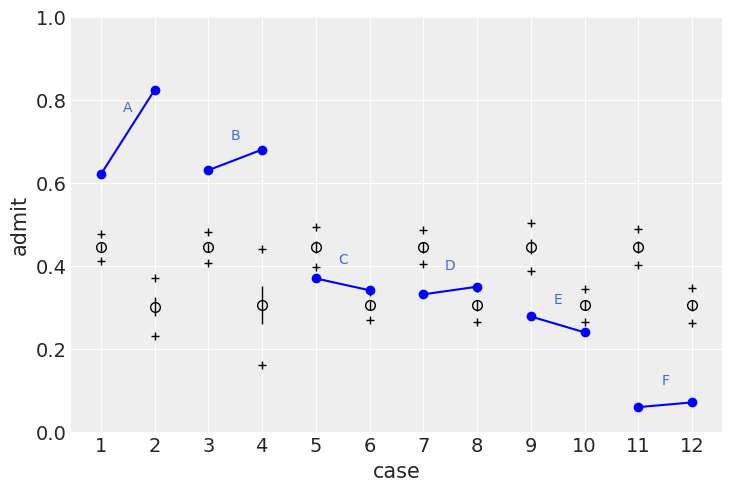

In [31]:
post = m11_7.get_samples()
admit_pred = Predictive(m11_7.sampler.model, post)(
    random.PRNGKey(2), gid=dat_list["gid"], applications=dat_list["applications"]
)["admit"]
admit_rate = admit_pred / d.applications.values
plt.errorbar(
    range(1, 13),
    jnp.mean(admit_rate, 0),
    jnp.std(admit_rate, 0) / 2,
    fmt="o",
    c="k",
    mfc="none",
    ms=7,
    elinewidth=1,
)
plt.plot(range(1, 13), jnp.percentile(admit_rate, 5.5, 0), "k+")
plt.plot(range(1, 13), jnp.percentile(admit_rate, 94.5, 0), "k+")
# draw lines connecting points from same dept
for i in range(1, 7):
    x = 1 + 2 * (i - 1)
    y1 = d.admit.iloc[x - 1] / d.applications.iloc[x - 1]
    y2 = d.admit.iloc[x] / d.applications.iloc[x]
    plt.plot((x, x + 1), (y1, y2), "bo-")
    plt.annotate(
        d.dept.iloc[x], (x + 0.5, (y1 + y2) / 2 + 0.05), ha="center", color="royalblue"
    )
plt.gca().set(ylim=(0, 1), xticks=range(1, 13), ylabel="admit", xlabel="case")
plt.show()

### Code 11.32

In [32]:
dat_list["dept_id"] = jnp.repeat(jnp.arange(6), 2)


def model(gid, dept_id, applications, admit=None):
    a = numpyro.sample("a", dist.Normal(0, 1.5).expand([2]))
    delta = numpyro.sample("delta", dist.Normal(0, 1.5).expand([6]))
    logit_p = a[gid] + delta[dept_id]
    numpyro.sample("admit", dist.Binomial(applications, logits=logit_p), obs=admit)


m11_8 = MCMC(NUTS(model), 2000, 2000, num_chains=4)
m11_8.run(random.PRNGKey(0), **dat_list)
m11_8.print_summary(0.89)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]     -0.52      0.53     -0.51     -1.38      0.33    602.91      1.00
      a[1]     -0.42      0.54     -0.41     -1.34      0.38    601.56      1.00
  delta[0]      1.10      0.54      1.09      0.26      1.97    608.08      1.00
  delta[1]      1.06      0.54      1.05      0.22      1.93    619.47      1.00
  delta[2]     -0.16      0.54     -0.17     -1.03      0.70    606.81      1.00
  delta[3]     -0.19      0.54     -0.20     -1.06      0.67    608.44      1.00
  delta[4]     -0.63      0.54     -0.64     -1.46      0.27    614.63      1.00
  delta[5]     -2.19      0.55     -2.20     -3.11     -1.35    609.85      1.00

Number of divergences: 0


### Code 11.33

In [33]:
post = m11_8.get_samples()
diff_a = post["a"][:, 0] - post["a"][:, 1]
diff_p = expit(post["a"][:, 0]) - expit(post["a"][:, 1])
print_summary({"diff_a": diff_a, "diff_p": diff_p}, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
    diff_a     -0.10      0.08     -0.09     -0.22      0.04   9673.17      1.00
    diff_p     -0.02      0.02     -0.02     -0.05      0.01   8139.33      1.00



### Code 11.34

In [34]:
pg = jnp.stack(
    list(
        map(
            lambda k: jnp.divide(
                d.applications[dat_list["dept_id"].copy() == k].values,
                d.applications[dat_list["dept_id"].copy() == k].sum(),
            ),
            range(6),
        )
    ),
    axis=0,
).T
pg = pd.DataFrame(pg, index=["male", "female"], columns=d.dept.unique())
pg.round(2)

,A,B,C,D,E,F
male,0.88,0.96,0.35,0.53,0.33,0.52
female,0.12,0.04,0.65,0.47,0.67,0.48


### Code 11.35

In [35]:
y = dist.Binomial(1000, 1 / 1000).sample(random.PRNGKey(0), (int(1e5),))
jnp.mean(y), jnp.var(y)

(DeviceArray(0.99553, dtype=float32), DeviceArray(1.0001298, dtype=float32))

### Code 11.36

In [36]:
Kline = pd.read_csv("../data/Kline.csv", sep=";")
d = Kline
d

,culture,population,contact,total_tools,mean_TU
0,Malekula,1100,low,13,3.2
1,Tikopia,1500,low,22,4.7
2,Santa Cruz,3600,low,24,4.0
3,Yap,4791,high,43,5.0
4,Lau Fiji,7400,high,33,5.0
5,Trobriand,8000,high,19,4.0
6,Chuuk,9200,high,40,3.8
7,Manus,13000,low,28,6.6
8,Tonga,17500,high,55,5.4
9,Hawaii,275000,low,71,6.6


### Code 11.37

In [37]:
d["P"] = d.population.apply(math.log).pipe(lambda x: (x - x.mean()) / x.std())
d["contact_id"] = (d.contact == "high").astype(int)

### Code 11.38

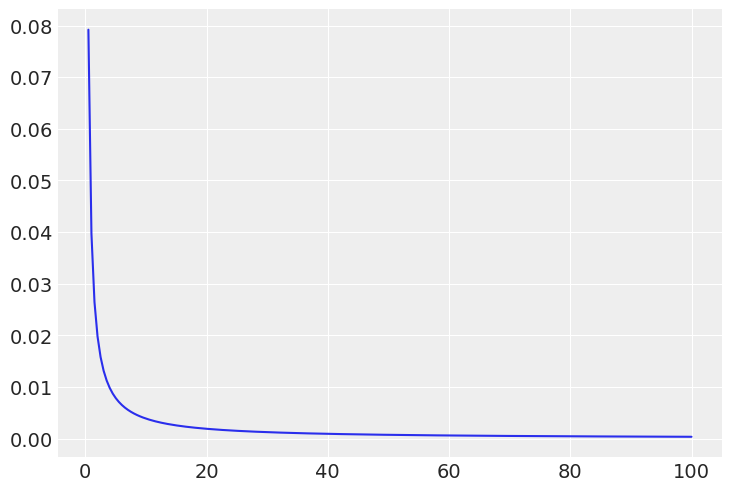

In [38]:
x = jnp.linspace(0, 100, 200)
plt.plot(x, jnp.exp(dist.LogNormal(0, 10).log_prob(x)))
plt.show()

### Code 11.39

In [39]:
a = dist.Normal(0, 10).sample(random.PRNGKey(0), (int(1e4),))
lambda_ = jnp.exp(a)
jnp.mean(lambda_)

DeviceArray(1.172584e+12, dtype=float32)

### Code 11.40

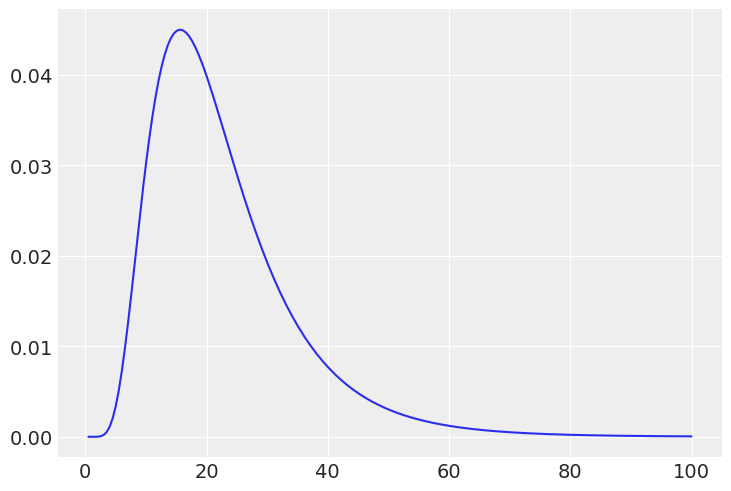

In [40]:
x = jnp.linspace(0, 100, 200)
plt.plot(x, jnp.exp(dist.LogNormal(3, 0.5).log_prob(x)))
plt.show()

### Code 11.41

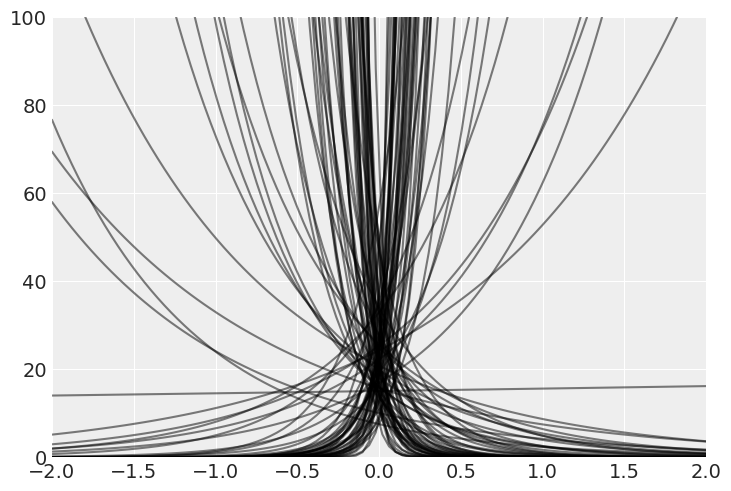

In [41]:
N = 100
a = dist.Normal(3, 0.5).sample(random.PRNGKey(0), (N,))
b = dist.Normal(0, 10).sample(random.PRNGKey(1), (N,))
plt.subplot(xlim=(-2, 2), ylim=(0, 100))
x = jnp.linspace(-2, 2, 100)
for i in range(N):
    plt.plot(x, jnp.exp(a[i] + b[i] * x), c="k", alpha=0.5)

### Code 11.42

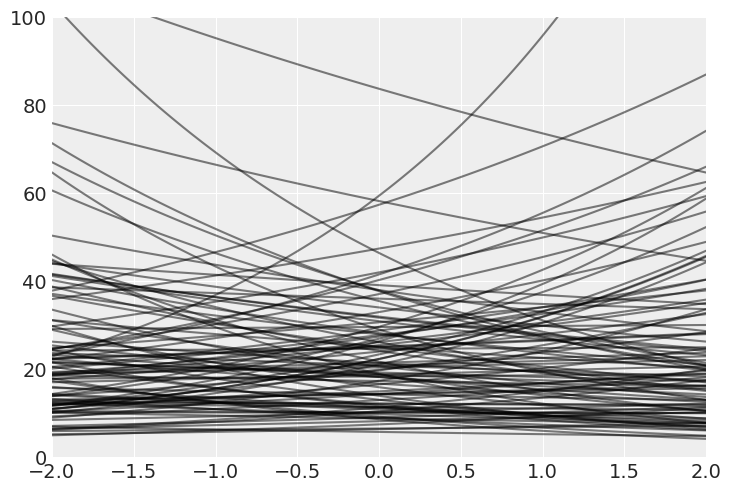

In [42]:
with numpyro.handlers.seed(rng_seed=10):
    N = 100
    a = numpyro.sample("a", dist.Normal(3, 0.5).expand([N]))
    b = numpyro.sample("a", dist.Normal(0, 0.2).expand([N]))
    plt.subplot(xlim=(-2, 2), ylim=(0, 100))
    x = jnp.linspace(-2, 2, 100)
    for i in range(N):
        plt.plot(x, jnp.exp(a[i] + b[i] * x), c="k", alpha=0.5)

### Code 11.43

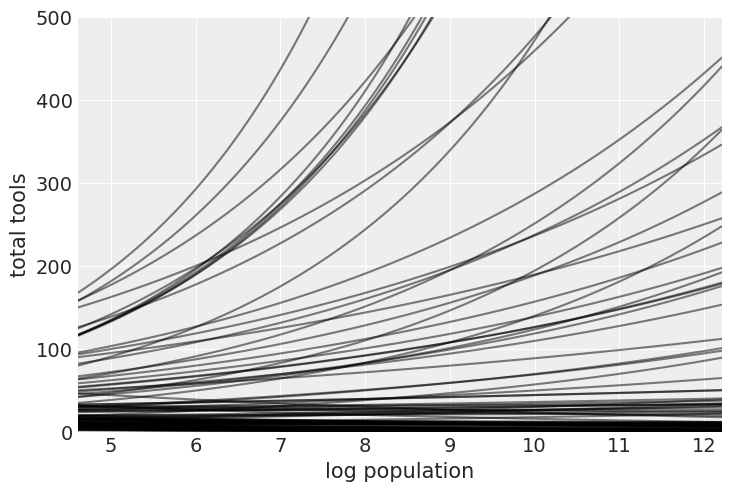

In [43]:
x_seq = jnp.linspace(jnp.log(100), jnp.log(200000), num=100)
lambda_ = vmap(lambda x: jnp.exp(a + b * x), out_axes=1)(x_seq)
plt.subplot(
    xlim=(jnp.min(x_seq).item(), jnp.max(x_seq).item()),
    ylim=(0, 500),
    xlabel="log population",
    ylabel="total tools",
)
for i in range(N):
    plt.plot(x_seq, lambda_[i], c="k", alpha=0.5)

### Code 11.44

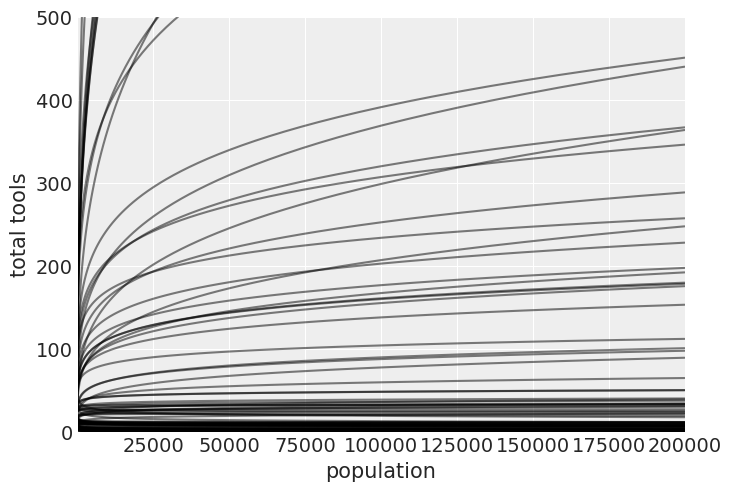

In [44]:
plt.subplot(
    xlim=(jnp.min(jnp.exp(x_seq)).item(), jnp.max(jnp.exp(x_seq)).item()),
    ylim=(0, 500),
    xlabel="population",
    ylabel="total tools",
)
for i in range(N):
    plt.plot(jnp.exp(x_seq), lambda_[i], c="k", alpha=0.5)

### Code 11.45

In [45]:
dat = dict(T=d.total_tools.values, P=d.P.values, cid=d.contact_id.values)

# intercept only
def model(T=None):
    a = numpyro.sample("a", dist.Normal(3, 0.5))
    lambda_ = numpyro.deterministic("lambda", jnp.exp(a))
    numpyro.sample("T", dist.Poisson(lambda_), obs=T)


m11_9 = MCMC(NUTS(model), 500, 500, num_chains=4)
m11_9.run(random.PRNGKey(0), dat["T"])

# interaction model
def model(cid, P, T=None):
    a = numpyro.sample("a", dist.Normal(3, 0.5).expand([2]))
    b = numpyro.sample("b", dist.Normal(0, 0.2).expand([2]))
    lambda_ = numpyro.deterministic("lambda", jnp.exp(a[cid] + b[cid] * P))
    numpyro.sample("T", dist.Poisson(lambda_), obs=T)


m11_10 = MCMC(NUTS(model), 500, 500, num_chains=4)
m11_10.run(random.PRNGKey(0), **dat)

### Code 11.46

In [46]:
az.compare(
    {"m11.9": az.from_numpyro(m11_9), "m11.10": az.from_numpyro(m11_10)},
    ic="loo",
    scale="deviance",
)

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m11.10,0,84.4813,6.54846,0,0.99557,30.8495,0,True,deviance
m11.9,1,140.925,7.82362,56.4441,0.00442981,11.6414,30.7639,False,deviance


### Code 11.47

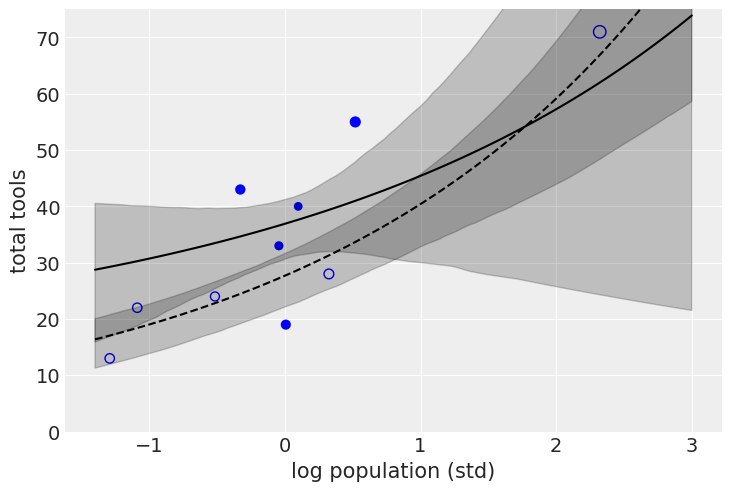

In [47]:
k = az.loo(az.from_numpyro(m11_10), pointwise=True).pareto_k.values
cex = 1 + (k - jnp.min(k)) / (jnp.max(k) - jnp.min(k))
plt.scatter(
    dat["P"],
    dat["T"],
    s=40 * cex,
    edgecolors=["none" if i == 1 else "b" for i in dat["cid"]],
    facecolors=["none" if i == 0 else "b" for i in dat["cid"]],
)
plt.gca().set(xlabel="log population (std)", ylabel="total tools", ylim=(0, 75))

# set up the horizontal axis values to compute predictions at
ns = 100
P_seq = jnp.linspace(-1.4, 3, num=ns)

# predictions for cid=0 (low contact)
lambda_ = Predictive(m11_10.sampler.model, m11_10.get_samples())(
    random.PRNGKey(1), P=P_seq, cid=0
)["lambda"]
lmu = jnp.mean(lambda_, 0)
lci = jnp.percentile(lambda_, (0.55, 94.5), 0)
plt.plot(P_seq, lmu, "k--", lw=1.5)
plt.fill_between(P_seq, lci[0], lci[1], color="k", alpha=0.2)

# predictions for cid=1 (high contact)
lambda_ = Predictive(m11_10.sampler.model, m11_10.get_samples())(
    random.PRNGKey(1), P=P_seq, cid=1
)["lambda"]
lmu = jnp.mean(lambda_, 0)
lci = jnp.percentile(lambda_, (0.55, 94.5), 0)
plt.plot(P_seq, lmu, "k", lw=1.5)
plt.fill_between(P_seq, lci[0], lci[1], color="k", alpha=0.2)
plt.show()

### Code 11.48

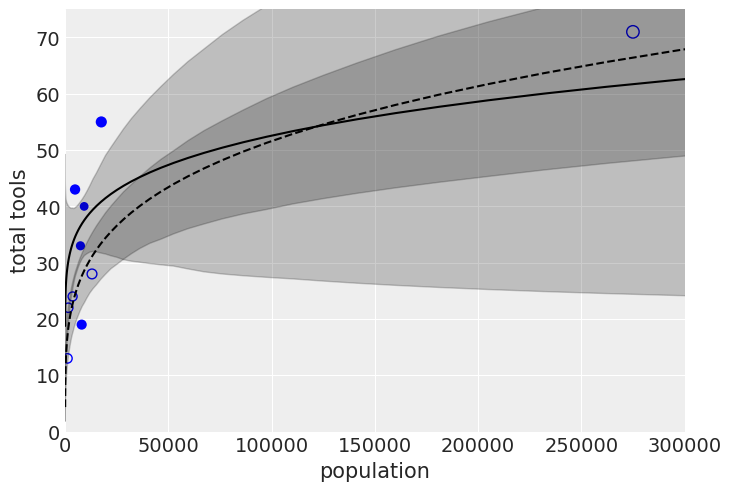

In [48]:
cex = 1 + (k - jnp.min(k)) / (jnp.max(k) - jnp.min(k))
plt.scatter(
    d.population,
    d.total_tools,
    s=40 * cex,
    edgecolors=["none" if i == 1 else "b" for i in dat["cid"]],
    facecolors=["none" if i == 0 else "b" for i in dat["cid"]],
)
plt.gca().set(xlabel="population", ylabel="total tools", xlim=(0, 300000), ylim=(0, 75))

ns = 100
P_seq = jnp.linspace(-5, 3, num=ns)
# 1.53 is sd of log(population)
# 9 is mean of log(population)
pop_seq = jnp.exp(P_seq * 1.53 + 9)

lambda_ = Predictive(m11_10.sampler.model, m11_10.get_samples())(
    random.PRNGKey(1), P=P_seq, cid=0
)["lambda"]
lmu = jnp.mean(lambda_, 0)
lci = jnp.percentile(lambda_, (0.55, 94.5), 0)
plt.plot(pop_seq, lmu, "k--", lw=1.5)
plt.fill_between(pop_seq, lci[0], lci[1], color="k", alpha=0.2)

lambda_ = Predictive(m11_10.sampler.model, m11_10.get_samples())(
    random.PRNGKey(1), P=P_seq, cid=1
)["lambda"]
lmu = jnp.mean(lambda_, 0)
lci = jnp.percentile(lambda_, (0.55, 94.5), 0)
plt.plot(pop_seq, lmu, "k", lw=1.5)
plt.fill_between(pop_seq, lci[0], lci[1], color="k", alpha=0.2)
plt.show()

### Code 11.49

In [49]:
dat2 = dict(T=d.total_tools.values, P=d.population.values, cid=d.contact_id.values)


def model(cid, P, T):
    a = numpyro.sample("a", dist.Normal(1, 1).expand([2]))
    b = numpyro.sample("b", dist.Exponential(1).expand([2]))
    g = numpyro.sample("g", dist.Exponential(1))
    lambda_ = jnp.exp(a[cid]) * jnp.power(P, b[cid]) / g
    numpyro.sample("T", dist.Poisson(lambda_), obs=T)


m11_11 = MCMC(NUTS(model), 500, 500, num_chains=4)
m11_11.run(random.PRNGKey(0), **dat2)

### Code 11.50

In [50]:
num_days = 30
y = dist.Poisson(1.5).sample(random.PRNGKey(0), (num_days,))

### Code 11.51

In [51]:
num_weeks = 4
y_new = dist.Poisson(0.5 * 7).sample(random.PRNGKey(0), (num_weeks,))

### Code 11.52

In [52]:
y_all = jnp.concatenate([y, y_new])
exposure = jnp.concatenate([jnp.repeat(1, 30), jnp.repeat(7, 4)])
monastery = jnp.concatenate([jnp.repeat(0, 30), jnp.repeat(1, 4)])
d = pd.DataFrame.from_dict(dict(y=y_all, days=exposure, monastery=monastery))

### Code 11.53

In [53]:
# compute the offset
d["log_days"] = d.days.apply(math.log)


def model(log_days, monastery, y):
    a = numpyro.sample("a", dist.Normal(0, 1))
    b = numpyro.sample("b", dist.Normal(0, 1))
    lambda_ = jnp.exp(log_days + a + b * monastery)
    numpyro.sample("T", dist.Poisson(lambda_), obs=y)


m11_12 = MCMC(NUTS(model), 500, 500)
m11_12.run(random.PRNGKey(0), d.log_days.values, d.monastery.values, d.y.values)

sample: 100%|██████████| 1000/1000 [00:04<00:00, 226.21it/s, 7 steps of size 7.06e-01. acc. prob=0.94]


### Code 11.54

In [54]:
post = m11_12.get_samples()
lambda_old = jnp.exp(post["a"])
lambda_new = jnp.exp(post["a"] + post["b"])
print_summary(dict(lambda_old=lambda_old, lambda_new=lambda_new), 0.89, False)


                  mean       std    median      5.5%     94.5%     n_eff     r_hat
  lambda_new      0.54      0.14      0.53      0.34      0.72    268.55      1.00
  lambda_old      1.68      0.24      1.66      1.26      2.01    190.92      1.00



### Code 11.55

In [55]:
# simulate career choices among 500 individuals
N = 500  # number of individuals
income = jnp.array([1, 2, 5])  # expected income of each career
score = 0.5 * income  # scores for each career, based on income
# next line converts scores to probabilities
p = nn.softmax(score)

# now simulate choice
# outcome career holds event type values, not counts
career = jnp.repeat(jnp.nan, N)  # empty vector of choices for each individual
# sample chosen career for each individual
for i in range(N):
    career = ops.index_update(
        career, i, dist.Categorical(probs=p).sample(random.PRNGKey(34302 + i))
    )
career = career.astype(jnp.int32)

### Code 11.56

In [56]:
def model_m11_13(N, K, career_income, career):
    # intercepts
    a = numpyro.sample("a", dist.Normal(0, 1).expand([K - 1]))
    # association of income with choice
    b = numpyro.sample("b", dist.HalfNormal(0.5))
    s_1 = a[0] + b * career_income[0]
    s_2 = a[1] + b * career_income[1]
    s_3 = 0  # pivot
    p = nn.softmax(jnp.stack([s_1, s_2, s_3]))
    numpyro.sample("career", dist.Categorical(p), obs=career)

### Code 11.57

In [57]:
dat_list = dict(N=N, K=3, career=career, career_income=income)
m11_13 = MCMC(NUTS(model_m11_13), 1000, 1000, num_chains=4)
m11_13.run(random.PRNGKey(0), **dat_list)
m11_13.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]     -2.19      0.19     -2.17     -2.52     -1.90    166.63      1.04
      a[1]     -1.81      0.26     -1.76     -2.18     -1.40     69.23      1.07
         b      0.13      0.11      0.10      0.00      0.29     71.42      1.07

Number of divergences: 90


### Code 11.58

In [58]:
post = m11_13.get_samples()

# set up logit scores
s1 = post["a"][:, 0] + post["b"] * income[0]
s2_orig = post["a"][:, 1] + post["b"] * income[1]
s2_new = post["a"][:, 1] + post["b"] * income[1] * 2

# compute probabilities for original and counterfactual
p_orig = vmap(lambda s1, s2: nn.softmax(jnp.stack([s1, s2, 0])))(s1, s2_orig)
p_new = vmap(lambda s1, s2: nn.softmax(jnp.stack([s1, s2, 0])))(s1, s2_new)

# summarize
p_diff = p_new[:, 1] - p_orig[:, 1]
print_summary(p_diff, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
   Param:0      0.04      0.04      0.03      0.00      0.09     75.58      1.02



### Code 11.59

In [59]:
N = 500
# simulate family incomes for each individual
family_income = dist.Uniform().sample(random.PRNGKey(0), (N,))
# assign a unique coefficient for each type of event
b = jnp.array([-2, 0, 2])
career = jnp.repeat(jnp.nan, N)  # empty vector of choices for each individual
for i in range(N):
    score = 0.5 * jnp.arange(1, 4) + b * family_income[i]
    p = nn.softmax(score)
    career = ops.index_update(
        career, i, dist.Categorical(probs=p).sample(random.PRNGKey(34302 + i))
    )
career = career.astype(jnp.int32)


def model_m11_14(N, K, family_income, career):
    # intercepts
    a = numpyro.sample("a", dist.Normal(0, 1.5).expand([K - 1]))
    # coefficients on family income
    b = numpyro.sample("b", dist.Normal(0, 1).expand([K - 1]))
    s = a + b * family_income[..., None]
    s_K = jnp.zeros((N, 1))  # the pivot
    p = nn.softmax(jnp.concatenate([s, s_K], -1))
    numpyro.sample("career", dist.Categorical(p), obs=career)


dat_list = dict(N=N, K=3, career=career, family_income=family_income)
m11_14 = MCMC(NUTS(model_m11_14), 1000, 1000, num_chains=4)
m11_14.run(random.PRNGKey(0), **dat_list)
m11_14.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]     -1.43      0.27     -1.43     -1.86     -0.98   2077.89      1.00
      a[1]     -0.57      0.20     -0.57     -0.88     -0.21   1681.98      1.00
      b[0]     -2.53      0.57     -2.52     -3.52     -1.67   2200.03      1.00
      b[1]     -2.18      0.42     -2.17     -2.81     -1.45   1792.31      1.00

Number of divergences: 0


### Code 11.60

In [60]:
UCBadmit = pd.read_csv("../data/UCBadmit.csv", sep=";")
d = UCBadmit

### Code 11.61

In [61]:
# binomial model of overall admission probability
def model(applications, admit):
    a = numpyro.sample("a", dist.Normal(0, 100))
    logit_p = a
    numpyro.sample("admit", dist.Binomial(applications, logits=logit_p), obs=admit)


m_binom = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m_binom,
    optim.Adam(1),
    Trace_ELBO(),
    applications=d.applications.values,
    admit=d.admit.values,
)
p_binom, losses = svi.run(random.PRNGKey(0), 1000)

# Poisson model of overall admission rate and rejection rate
d["rej"] = d.reject


def model(rej, admit):
    a1, a2 = numpyro.sample("a", dist.Normal(0, 100).expand([2]))
    lambda1 = jnp.exp(a1)
    lambda2 = jnp.exp(a2)
    numpyro.sample("rej", dist.Poisson(lambda2), obs=rej)
    numpyro.sample("admit", dist.Poisson(lambda1), obs=admit)


m_pois = MCMC(NUTS(model), 1000, 1000, num_chains=3)
m_pois.run(random.PRNGKey(0), d.rej.values, d.admit.values)

100%|██████████| 1000/1000 [00:00<00:00, 1531.69it/s, init loss: 734.6700, avg. loss [951-1000]: 468.9513]


### Code 11.62

In [62]:
expit(m_binom.median(p_binom)["a"])

DeviceArray(0.3877594, dtype=float32)

### Code 11.63

In [63]:
k = jnp.mean(m_pois.get_samples()["a"], 0)
a1 = k[0]
a2 = k[1]
jnp.exp(a1) / (jnp.exp(a1) + jnp.exp(a2))

DeviceArray(0.38772315, dtype=float32)

<!-- NAVIGATION -->
< [Chapter 10. Big Entropy and the Generalized Linear Model](10-big-entropy-and-the-generalized-linear-model.html) | [Chapter 12. Monsters and Mixtures](12-monsters-and-mixtures.html) >